In [1]:
import csv
import pandas as pd
from typing import Any, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("data/oura_hr.csv", header=0)
df['timestamp']=pd.to_datetime(df['timestamp']).dt.date
df.head(10)

,timestamp,bpm,quality,source,restorative
0,2021-11-29,88,good,awake,False
1,2021-11-29,98,good,awake,False
2,2021-11-29,94,good,awake,False
3,2021-11-29,108,average,awake,False
4,2021-11-29,120,average,awake,False
5,2021-11-29,124,average,awake,False
6,2021-11-29,94,good,awake,False
7,2021-11-29,90,good,awake,False
8,2021-11-29,95,good,awake,False
9,2021-11-29,89,good,awake,False


In [3]:
# aggregate daily numbers to: avg, mode, max, min
groupped_df = df.drop(['quality', 'source', 'restorative'], axis=1)

results_structure = {"day": [], "min":[], "max":[], "avg":[]}
def populate(input_dict: dict, input_array: Any, key: str):
    """ Helper iteration over dict and groupped DFs """
    for idx, value in input_array.items():
        if idx.isoformat() not in input_dict["day"]:
            input_dict["day"].append(idx.isoformat())
        if key == "avg":
            input_dict[key].append(int(value))
        else:
            input_dict[key].append(value)

lowest = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.min)
populate(results_structure, lowest, "min")
highest = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.max)
populate(results_structure, highest, "max")
avg = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.mean)
populate(results_structure, avg, "avg")
# mode = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.median())
# populate(results_structure, mode, "median")

bpm = pd.DataFrame.from_dict(results_structure)
bpm['day']=bpm['day'].astype(str)
bpm.head()

,day,min,max,avg
0,2021-11-29,61,124,85
1,2021-11-30,64,122,80
2,2021-12-01,64,147,82
3,2021-12-02,65,118,86
4,2021-12-03,37,127,83


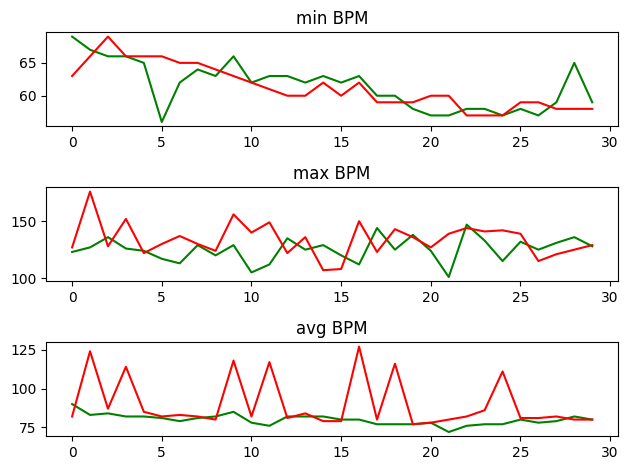

In [4]:
def plot_simple_period(df: pd.DataFrame, first_start: str, second_start: str, duration: int, plots: List[str]):
    """ Plot 3 metrics in separate figures for comparable time horizons """
    if first_start not in df['day'].tolist():
        raise Exception(f"No data was recorded for the start date: {first_start}")
    else:
        indx_start_1 = df.index[bpm['day'] == first_start].tolist()[0]
        indx_end_1 = indx_start_1 + duration

    if second_start not in df['day'].tolist():
        raise Exception(f"No data was recorded for this second start date: {second_start}")
    else:
        indx_start_2 = df.index[bpm['day'] == second_start].tolist()[0]
        indx_end_2 = indx_start_2 + duration
   
    x = [i for i in range(0, duration)]
    fig, axs = plt.subplots(len(plots))
        
    for idx, item in enumerate(plots):
        y1 = df[item][indx_start_1:indx_end_1]
        y2 = df[item][indx_start_2:indx_end_2]
        axs[idx].plot(x, y1, label=f'{item} BPM', color='green')
        axs[idx].plot(x, y2, color='red')
        axs[idx].set_title(f"{item} BPM")

    fig.tight_layout()
    
    
plot_simple_period(bpm, '2022-01-01', '2023-01-01', 30, ["min", "max", "avg"]) 


In [24]:
df_sleep = pd.read_csv("data/oura_sleep.csv", header=0)
df_sleep['day'] = pd.to_datetime(df_sleep['day']).dt.date
df_sleep.head()

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,time_in_bed,total_sleep_duration
0,19.500,68.09,37.0,4410.0,2021-11-30T09:01:08.000+01:00,2021-11-30T00:33:08.000+01:00,2021-11-30,5790.0,12210.0,8070.0,30480,26070.0
1,19.500,82.00,27.0,1200.0,2021-11-30T19:38:49.000+01:00,2021-11-30T19:17:49.000+01:00,2021-12-01,30.0,30.0,0.0,1260,60.0
2,18.375,66.44,42.0,6420.0,2021-12-01T07:20:18.000+01:00,2021-11-30T23:48:18.000+01:00,2021-12-01,5940.0,10230.0,4530.0,27120,20700.0
3,18.375,72.00,NaN,360.0,2021-12-01T12:19:47.000+01:00,2021-12-01T12:13:47.000+01:00,2021-12-01,0.0,0.0,0.0,360,0.0
4,18.375,76.33,45.0,1050.0,2021-12-01T18:46:03.000+01:00,2021-12-01T18:26:03.000+01:00,2021-12-02,0.0,150.0,0.0,1200,150.0


In [75]:
def prepare_data(df_in: pd.DataFrame, start_in: str, 
                 duration: int, column: str = 'deep_sleep_duration', 
                 normalize: bool = True) -> pd.Series:
    """Clean and prepare separate series from dataframe """
    df_in = df_in[[column, 'day']]
    groupped = df_in.groupby('day').sum()
    dfsleep = pd.DataFrame({
        column: groupped[column],
    })
    ideces = dfsleep.index.tolist()
    s = dfsleep.index.tolist().index(dt.datetime.strptime(start_in, "%Y-%m-%d").date())
    e = s + duration
    dfsleep = dfsleep[s:e]
    if normalize:
        dfsleep[column] = dfsleep[column].apply(lambda x: x / 60)
    idx = pd.date_range(start=min(dfsleep.index), end=max(dfsleep.index), inclusive="both")
    values = []
    for i in idx.tolist():
        if i.date() in dfsleep.index.tolist():
            values.append(dfsleep.loc[i.date()])
        else:
            values.append(np.nan)   
    sleep = pd.Series(values, index=idx)
    series_prepared = sleep.ffill()
    
    return series_prepared


def plot_raw_timeseries(df_in: pd.DataFrame, start: str, end: str, duration: int, 
                        column: str = 'deep_sleep_duration', multiple: bool = False,
                        hp_on: bool = False):
    """ Simpest TS analysis and plotting """
    plots = 4
    if hp_on:
        plots = 3
    fig, axs = plt.subplots(plots)
    
    def decompose(series: pd.Series) -> Tuple[List, List, List]:
        """ seasonal decomposition """
        decomposition = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
        return decomposition.trend, decomposition.seasonal, decomposition.resid
    
    def plot_decomposition(origin: List, trend: List, cycle: List, noise: List, color: str):
        axs[0].plot(origin, label='Original', color=color)
        axs[0].legend(loc='best')
        axs[1].plot([i for i in range(0, len(trend))], trend, label='Trend', color=color)
        axs[1].legend(loc='best')
        axs[2].plot([i for i in range(0, len(cycle))], cycle, label='Cycles', color=color)
        axs[2].legend(loc='best')
        if not hp_on:
            axs[3].plot([i for i in range(0, len(noise))], noise, label='Noise', color=color)
            axs[3].legend(loc='best')
    
    first_period = prepare_data(df_in, start, duration, column, True)
#     max_first, min_first = max(first_period[column]), min(first_period[column])
    trend1, cycles1, noise1 = decompose(first_period)
    # Hodrick-Prescott filter: 
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html
    if hp_on:
        cycles1, trend1 = sm.tsa.filters.hpfilter(first_period, 1600 * 3 ** 4)
        if multiple:
            second_period = prepare_data(df_in, end, duration, column, True)
            trend2, cycles2, noise2 = decompose(second_period)
            cycles2, trend2 = sm.tsa.filters.hpfilter(second_period, 1600 * 3 ** 4) 
    
#     print(f"In the first period: \n max duration:{max_first} \n min duration: {min_first} \n avg duration: TBD")
    plot_decomposition(first_period.tolist(), trend1, cycles1, noise1, 'blue')
    
    if multiple:
        plot_decomposition(second_period.tolist(), trend2, cycles2, noise2, 'red')

    fig.tight_layout()


/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


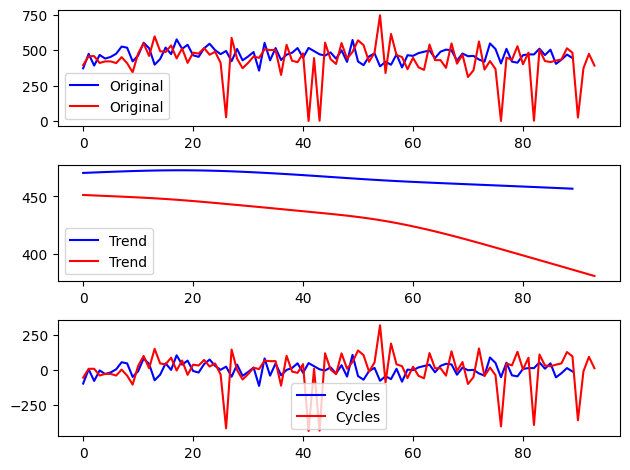

In [76]:
plot_raw_timeseries(df_in = df_sleep, 
                    start='2022-01-01', 
                    end='2023-01-01', duration=90,
                    column='total_sleep_duration',
                    multiple=True,
                    hp_on=True)

/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


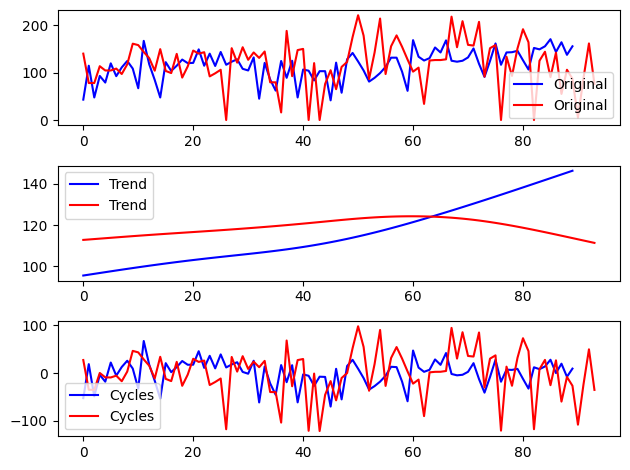

In [66]:
plot_raw_timeseries(df_in = df_sleep, 
                    start='2022-01-01', 
                    end='2023-01-01', duration=90,
                    column='deep_sleep_duration',
                    multiple=True,
                    hp_on=True)

/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


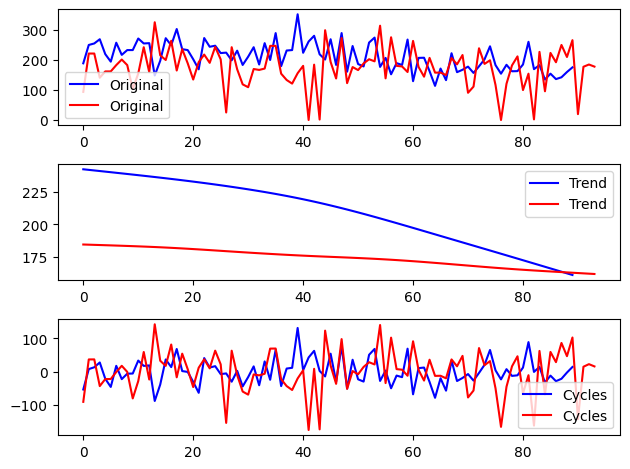

In [67]:
plot_raw_timeseries(df_in = df_sleep, 
                    start='2022-01-01', 
                    end='2023-01-01', duration=90,
                    column='light_sleep_duration',
                    multiple=True,
                    hp_on=True)

/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


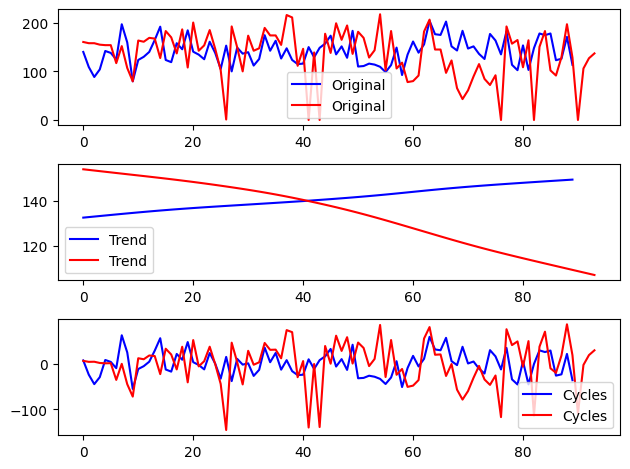

In [68]:
plot_raw_timeseries(df_in = df_sleep, 
                    start='2022-01-01', 
                    end='2023-01-01', duration=90,
                    column='rem_sleep_duration',
                    multiple=True,
                    hp_on=True)
